 # MNIST를 이용하여 Stable Diffusion 아키텍처 구현

라이브러리 임포트

In [63]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import functools as functions

from tqdm import tqdm



Stable Diffusion은 Diffusion, U-net, 오토인코더, 트랜스포머 어텐션 모델을 사용하여 텍스트 조건에서 이미지 생성을 가능하도록 함

+ VAE 오토인코더 : 입출력 데이터를 잠재공간차원에 매핑하여 계산 성능을 높임
+ 순방향 확산(foward diffusion) : 입력 이미지에서 점진적으로 노이즈 이미지로 계산, 학습용 데이터로 사용함
+ 역방향 확산(reverse difusion) : 노이즈에서 이미지를 생성하도록 함
+ U-net: 노이즈 예측에 사용
+ 컨디셔닝 : 텍스트에 따른 조건부 이미 생성에 사용, CLIP 모델과 같은 트랜스포머 어텐션 사용

MNIST 데이터셋을 불러오기

In [27]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset=torchvision.datasets.MNIST(root='../data',train=True,transform=transform,download=True)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)

불러온 데이터셋 이미지 확인

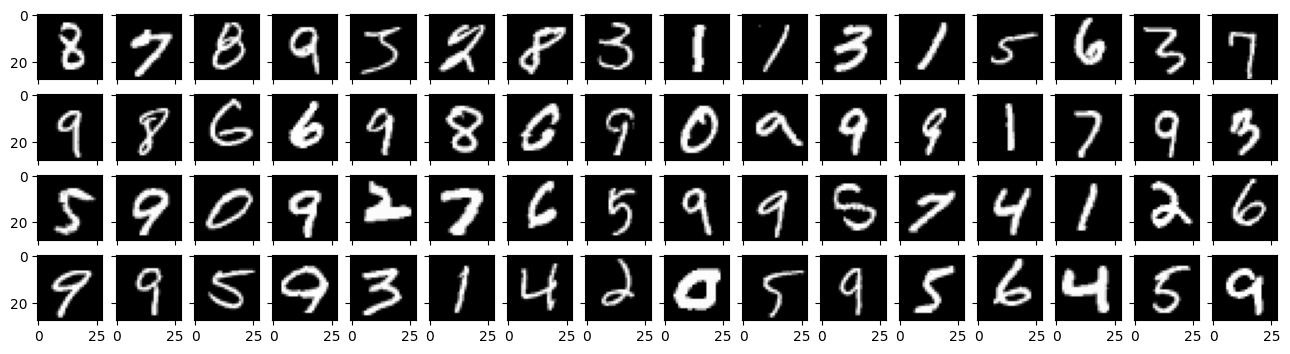

In [28]:
unique_images,unique_labels=next(iter(train_loader))
unique_images=unique_images.numpy()
row,column=4,16
fig,axes=plt.subplots(row,column,figsize=(16,4),sharex=True,sharey=True)
for i in range(row):
    for j in range(column):
        index=i*column+j
        axes[i,j].imshow(unique_images[index].squeeze(0),cmap='gray')
plt.show()


# Diffusion 모델 설계

스테이블 디퓨전의 학습 목표
+ 역확산을 통해 잡음을 제거하여 원하는 데이터 생성
+ 잡음을 제거를 목표로 잡음을 제거하도록 신경망을 훈련

노이즈 제거 목적 방정식

<img src='./modify/1.png'>

p0(x0)은 목표의 분포로 예를 들어 생성하고자하는 이미지가 될수 있음

x(noise)는 순방향 확산 후 목표 분포 x0의 샘플을 의미

즉, (x(noise)-x0)는 정규 분포 확률 변수

<img src='./modify/2.png'>

J는 노이즈 제거 목표, E는 기대치, t는 시간 매개 변수(특정 시점), x0는 목표 분포인 p0(x(0))의 샘플, x(noise)는 한 단계 순확산 후 목표 샘플(노이즈가 추가된 데이터)

s()는 score 함수, σ(t)는 시간 함수  ε는 정규확률분포변수이다. 

# 시간 임베딩

score 함수는 시간에 따라 정확하게 신경망이 동작하도록 구현

-> 이를 위해 시간 임베딩을 사용

시간 임베딩은 트랜스포머의 위치 임베딩과 유사한 정현파를 사용해 시간특징 계산 가능

다양한 시간 표현을 학습 시 입력하여 시간 변화에 따라 확산 과정을 학습

시간종속적인 s(x,t)를 손실함수의 일부로 사용

시간 임베딩은 두개의 클래스로 구현

1. 가우스 랜덤 기능 모듈

학습 컨테스트에서 시간 단계를 표현하는데 사용

각 시간 단계 전반에 걸쳐 임이의 주파수 생성

시간단계 별 sin,cos 투영하여 시간 패턴 특징 계산

In [29]:
class GaussianFourierPorjection(nn.Module): # 시간 특징 계산 클래스스
    def __init__(self,embed_dim,scale=30):# 임베딩 차원, 랜덤 가중치(주파수)를 위한 스케일 변수
        super().__init__()
        self.W=nn.Parameter(torch.randn(embed_dim//2)*scale,requires_grad=False) #랜덤 샘플링, 훈련파라미터 X

    def forward(self,x):# 시간 단위 텐서 입력
        x_proj=x[:,None]*self.W[None,:]*2*np.pi # 2 x pi x 주파수 x
        return torch.cat([torch.sin(x_proj),torch.cos([x_proj])],dim=-1) #최종 sin, cos 결과 결합

2. 특징 텐서 계산

입력을 4D 특징 텐서로 출력하는 모듈

차원 재구성 작업은 다음 컨볼루션 처리에 적합한 맵으로 변경하기 위함

In [30]:
class Dense(nn.Module): #특징 계산 클래스
    def __init__(self, input_dim, output_dim):# 입력 차원, 출려 차원
        super().__init__()
        self.dense=nn.Linear(input_dim,output_dim)

    def forward(self,x):
        return self.dense(x)[...,None,None] # 마지막에 차원을 추가하여 4D 텐서로 변경

# U-net

이미지 특징을 캡처하기 위해 U-net을 사용

U-net은 시간에 따라 어떻게 데이터가 변경되는 지를 학습

U-net의 인코딩 경로를 통해 이미지 다운샘플링, 특징 캡처를 위해 h1,h2,h3,h4로 구성

디코딩 경로는 트랜스포즈 컨볼루션 레이어로 텐서 h가 h4에서 h1레이어를 통과하여 업샘플링

In [31]:
class Unet(nn.Module):
    def __init__(self,marginal_prob_std, channels=[32,64,128,256],embed_dim=256):
        """
        marginal_prob_std: 시간 t에 대한 표준편차 반환 함수
        channels: 각 해상도의 특징 맵의 채널 수
        embed_dim: 가우시안 랜덤 특징 임베딩 차원
        """
        super().__init__()

        self.time_embed=nn.Sequential( # 시간에 대한 가우시안 랜덤 특징 임베딩 계층
            GaussianFourierPorjection(embed_dim=embed_dim),
            nn.Linear(embed_dim,embed_dim)
        )

        # 인코딩 레이어 구현
        self.conv1=nn.Conv2d(1,channels[0],kernel_size=3,stride=1,bias=False)# mnist여서 1채널
        self.dense1=Dense(embed_dim,channels[0])
        self.gnorm1=nn.GroupNorm(4,num_channels=channels[0]) # 그룹 정규화
        self.conv2=nn.Conv2d(channels[0],channels[1],kernel_size=3,stride=2,bias=False)
        self.dense2=Dense(embed_dim,channels[1])
        self.gnorm2=nn.GroupNorm(32,num_channels=channels[1])

        self.conv3=nn.Conv2d(channels[1],channels[2],kernel_size=3,stride=2,bias=False)
        self.dense3=Dense(embed_dim,channels[2])
        self.gnorm3=nn.GroupNorm(32,channels[2])
        self.conv4=nn.Conv2d(channels[2],channels[3],kernel_size=3,stride=2,bias=False)
        self.dense4=Dense(embed_dim,channels[3])
        self.gnorm4=nn.GroupNorm(32,num_channels=channels[3])

        # 디코딩 레이어 구현(해상도 증가)
        self.tconv4=nn.ConvTranspose2d(channels[3],channels[2],kernel_size=3,stride=2,bias=False)
        self.dense5=Dense(embed_dim,channels[2])
        self.tgnorm4=nn.GroupNorm(32,channels[2])
        self.tconv3=nn.ConvTranspose2d(channels[2], channels[1],kernel_size=3,stride=2,bias=False,output_padding=1)
        self.dense6=Dense(embed_dim,channels[1])
        self.tgnorm3=nn.GroupNorm(32,channels[1])

        self.tconv2=nn.ConvTranspose2d(channels[1],channels[0],kernel_size=3,stride=2,bias=False,output_padding=1)
        self.dense7=Dense(embed_dim,channels[0])
        self.tgnorm2=nn.GroupNorm(32,channels[0])
        self.tconv1=nn.ConvTranspose2d(channels[0],1,kernel_size=3,stride=1)

        # 스위시시 활성화 함수
        self.act=lambda x:x*torch.sigmoid(x)
        self.marginal_prob_std=marginal_prob_std

    def forward(self,x,t,y=None):
        """
        x는 입력텐서
        t는 시간 텐서
        y는 타겟 텐서
        h는 U-net을 통과한 출력텐서서
        """
        embed=self.act(self.time_embed(t))

        #인코딩
        h1=self.conv1(x)+self.dense1(embed)
        h1=self.act(self.gnorm1(h1))

        h2=self.conv2(h1)+self.dense2(embed)
        h2=self.act(self.gnorm2(h2))

        h3=self.conv3(h2)+self.dense3(embed)
        h3=self.act(self.gnorm3(h3))

        h4=self.conv4(h3)+self.dense4(embed)
        h4=self.act(self.gnorm4(h4))

        # 디코딩딩
        h=self.tconv4(h4)
        h+=self.dense5(embed)
        h=self.act(self.tgnorm4(h))

        h=self.tconv3(h+h3)
        h+=self.dense6(embed)
        h=self.act(self.tgnorm3(h))

        h=self.tconv2(h+h2)
        h+=self.dense7(embed)
        h=self.act(self.tgnorm2(h))

        h=self.tconv1(h+h1)

        h=h/self.marginal_prob_std(t)[:,None,None,None]

        return h



# 포워드 diffusion 프로세스

<img src='./modify/3.png'>

변수 x에 대한 변화가 시간 t에 대한 노이즈가 dw에 비례하는 방식으로 동작

노이즈 강도는  σ에 결정하며 지수적으로 증가

<img src='./modify/4.png'>

처음 x(0)가 주어지면 x(t)에 대한 분석 적인 솔루션 탐색 가능

모델에서  σ(t)는 표준 편차로 x(t)는 분산의 변동으로 사용 σ(t)는 다음과 같이 계산

<img src='./modify/5.png'>

시간에 따라 잡음 수준 σ가 정해지는지 이해를 제공



In [33]:
device='cuda'

def marginal_prob_std(t,sigma): # 시간 t 에 대한 표준 편차 반환 함수
    t=torch.tensor(t,device=device)
    return torch.sqrt((sigma**(2*t)-1)/2/np.log(sigma)) # sqrt 표준 편차 계산 (표준편차=분산의 제곱근)

def diffusion_coeff(t,sigma): # 확산 계산 함수수
    return torch.tenosr(sigma**t,device=device)

sigma=25.0
marginal_prob_std_fn=functions.partial(marginal_prob_std,sigma=sigma)
diffusion_coeff_fn=functions.partial(diffusion_coeff,sigma=sigma)


# 손실 함수 구현

score 함수를 학습할 수 있는 loss 함수 구현

시간단위를 샘플링하여 잡음 수준을 획득후 잡음을 데이터와 더함

실제 데이터와 예측 데이터간의 오차를 계산하여 에러를 줄이는 방향으로 학습

In [35]:
def loss_fn(model,x,marginal_prob_std,eps=1e-5):# 시간 의존 스코어 모델 x: 훈련데이터 미니배치
    random_t=torch.randn(x.shape[0],device=x.device)*(1-2*eps)+eps # 미니 배치 크기 만큼 랜덤시간 샘플링
    std=marginal_prob_std(random_t) #랜덤 시간에 대한 표준편차 계산
    z=torch.randn_like(x) # 미니배치 크기만큼 정규 분포 랜덤 노이즈 생성
    perturbed_x=x+z*std[:,None, None,None] # 노이즈로 입력데이터 왜곡

    score=model(perturbed_x,random_t)
    loss=torch.mean(torch.sum((score*std[:,None,None,None]+z)**2,dim=(1,2,3)))

    return loss

# 샘플러 코딩

Stable diffusion은 임의 시점에서 이미지를 생성

노이즈 예측기는 얼마나 이미지에 노이즈를 추가할 것인지 예측

예측된 노이즈는 이미지로부터 제거

이 과정을 clearning-up 프로세스라고 하며 "샘플링"으로 정의하고 있음

매 학습 단게마다 새로운 이미지를 생성되도록 한다. (이를 샘플러, 샘플링 방법이라고 정의)

Stable diffusion은 이미지 샘플링을 생성하기 위한 다양한 방법이 있지만 본 코드에서는 Euler-Maruyama 방법을 사용

In [64]:
num_steps=500

def Euler_Maruyama_sampler(
        score_model, # 시간 의존 스코어 모델
        marginal_prob_std, # 표준편차 반환 함수
        diffusion_coeff, # 확산 계수 함수
        batch_size=64,
        x_shape=(1,28,28),
        num_steps=num_steps,
        device=device,
        eps=1e-3, # 수치 안정성을 위한 허용값
        y=None # 타겟 텐서
):
    t=torch.ones(batch_size,device=device)
    init_x=torch.randn(batch_size,*x_shape,device=device) # [batch_size,channel, height, width]
    time_stpes=torch.linespace(1.,eps,num_steps,deivce=device) #[numsteps]

    step_size=time_stpes[0]-time_stpes[1] # Steip size 시리즈
    x=x=init_x # 시간 t에 대한 초기 샘플

    with torch.no_grad():
        for time_step in tqdm(time_stpes):
            batch_time_step=torch.ones(batch_size,device=device)*time_step
            g=diffusion_coeff(batch_time_step)
            mean_x=x+(g**2)[:,None,None,None]*score_model(x,batch_time_step,y=y)*step_size
            x=mean_x+torch.sqrt(step_size)*g[:,None,None,None]*torch.randn_like(x)

    return mean_x